# **MODELO XGBOOST**

A importância de usar o XGBoost, especialmente em problemas como o seu (multiclasse, dados de sensores, falhas em máquinas).

**Alto desempenho em classificação**

XGBoost é uma implementação de Gradient Boosting otimizada e regularizada.

Ele combina múltiplas árvores de decisão sequencialmente, cada uma corrigindo os erros da anterior.

Isso geralmente gera maior precisão e robustez do que modelos simples como Random Forest ou Decision Tree isolada.

**Lida bem com dados desequilibrados**

Em casos de classes desbalanceadas, como falhas raras, ele funciona bem com weights ou ajustes no objetivo.

Quando combinado com SMOTE, consegue aprender padrões mesmo de classes minoritária.


**Flexibilidade**

Suporta problemas multiclasse e regressão.

Permite escolher diferentes funções de perda (objective) e métricas (eval_metric) para otimizar exatamente o que importa (ex.: mlogloss para multiclasses).


**Controle de overfitting**

Possui regularização L1 e L2 (alpha e lambda) que ajudam a evitar overfitting.

Ajustes como max_depth, learning_rate e n_estimators permitem balancear complexidade vs generalização.




Detecção de falhas em máquinas: XGBoost consegue capturar interações complexas entre sensores (torque, velocidade, temperatura, etc.).

Classes desbalanceadas: minorias (falhas raras) ainda são detectáveis com SMOTE.

Multiclasse: identifica corretamente diferentes tipos de falha.

Feature importance: mostra quais variáveis merecem atenção na manutenção preventiva.

# **IMPACTO NA INDÚSTRIA**

A aplicação de modelos de machine learning, especialmente o XGBoost multirótulo, na manutenção preditiva industrial tem um impacto significativo na eficiência e segurança operacional. Ao analisar dados de sensores como temperatura, torque, velocidade e umidade, o modelo é capaz de identificar múltiplos tipos de falhas antes que elas ocorram, permitindo intervenções preventivas. Essa abordagem reduz custos com paradas emergenciais e reparos, aumenta a produtividade ao manter os equipamentos operando em condições ideais e melhora a segurança ao prevenir acidentes. Além disso, a interpretação da importância das features fornece insights valiosos sobre quais parâmetros têm maior influência em cada tipo de falha, apoiando decisões estratégicas de manutenção e alinhando a operação às práticas da Indústria 4.0, com monitoramento inteligente e manutenção baseada em dados em tempo real.

# **PROCESSOS REALIZADOS**

Pré-processamento de dados com imputação, normalização e codificação categórica.
Engenharia de atributos para enriquecer o conjunto de features com variáveis compostas.
Remoção de outliers por classe com base no intervalo interquartil (IQR).
Balanceamento das classes com a técnica de oversampling SMOTE.
Treinamento de um modelo do tipo XGBoost, com hiperparâmetros ajustados.
Validação com divisão estratificada e avaliação com a métrica F1-score macro, adequada para problemas com desbalanceamento de classes.
Geração de previsões e conversão para o formato binário exigido, com exportação final em CSV.

# **MODELAGEM**

As colunas com valores numéricos contínuos (sujeitas a outliers) são:

temperatura_ar (min = -36, max = 304.5 → possível erro/outlier)

temperatura_processo (min = -38, max = 313.8 → possível erro/outlier)

umidade_relativa (mínimo próximo de 80 e máximo 94 → parece consistente, poucos outliers)

velocidade_rotacional (min = -161, max = 2886 → valor negativo indica erro/outlier)

torque (min = 3.8, max = 76.6 → parece aceitável, mas verificar cauda)

desgaste_da_ferramenta (min = -202, max = 253 → valor negativo é outlier)

⚠ Observações:

Valores negativos em temperaturas, velocidade_rotacional e desgaste_da_ferramenta são fisicamente incoerentes → devem ser tratados.

temperatura acima de 310 pode ser outlier, considerando que 75% está em torno de 301.

velocidade_rotacional muito alta (2886) é suspeita (75% está em 1574).

torque é mais estável, mas pode ter outliers no extremo superior.

In [ ]:
#BIBLIOTECAS

import seaborn as sns

from xgboost import XGBClassifier               # Modelo XGBoost para classificação
import numpy as np                              # Biblioteca para operações numéricas
import pandas as pd                             # Leitura e manipulação de dados tabulares
import matplotlib.pyplot as plt                 # Visualização de gráficos

# Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split       # Divisão treino/teste
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  # Pré-processamento
from sklearn.compose import ColumnTransformer              # Aplicar transformação por tipo de coluna
from sklearn.pipeline import Pipeline                      # Encadeamento de passos de transformação
from sklearn.impute import SimpleImputer                   # Imputação de valores ausentes
from sklearn.metrics import classification_report          # Métricas de avaliação do modelo

# Para balanceamento de classes e pipeline integrado
from imblearn.over_sampling import SMOTE                   # Técnica de oversampling para classes minoritárias
from imblearn.pipeline import Pipeline as ImbPipeline      # Pipeline que aceita SMOTE




In [2]:
# Colunas que irei remover os outliers, remover de mais colunas reduzia muito a amostra.

top_features_outliers = [
     'desgaste_da_ferramenta',
    'velocidade_rotacional',
     'temperatura_ar',
     'torque',
     'temperatura_processo',
     'umidade_relativa'
]




In [3]:
# Remove as linhas que fogem do IQR nas colunas que foram especificadas acima

def remover_outliers_iqr(df, colunas):
    df_filtrado = df.copy()
    for col in colunas:
        q1 = df_filtrado[col].quantile(0.25)
        q3 = df_filtrado[col].quantile(0.75)
        iqr = q3 - q1
        limite_inf = q1 - 1.5 * iqr
        limite_sup = q3 + 1.5 * iqr
        df_filtrado = df_filtrado[
            (df_filtrado[col] >= limite_inf) &
            (df_filtrado[col] <= limite_sup)
        ]
    return df_filtrado

In [4]:
# Faz a remoção dos outliers para cada classe, evitando viés por volume de dados

def remover_outliers_por_classe(df, colunas, classe_col):
    df_filtrado = pd.DataFrame()
    for classe in df[classe_col].unique():
        df_classe = df[df[classe_col] == classe]
        df_classe_filtrado = remover_outliers_iqr(df_classe, colunas)
        df_filtrado = pd.concat([df_filtrado, df_classe_filtrado])
    return df_filtrado

In [5]:
import matplotlib.pyplot as plt
# Configurações para o plot
plt.style.use('ggplot')

In [6]:
# --- 1. Obtendo e Pré-processando os Dados ---
print("Iniciando o pré-processamento dos dados...")

Iniciando o pré-processamento dos dados...


In [10]:
import pandas as pd

df = pd.read_csv('/content/bootcamp_train.csv') #bootecamp train

In [16]:
# Criação da coluna classe_defeito, vai ser a nossa variável target
colunas_falha = ['falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)',
    ]


In [12]:
# 3. Verificar se já existe a coluna 'classe_defeito'
if 'classe_defeito' not in df.columns:
    # Manter apenas colunas que existem no dataset
    colunas_falha_existentes = [c for c in colunas_falha if c in df.columns]

    # Criar a coluna de classe a partir das colunas de falha
    def definir_classe(row):
        for col in colunas_falha_existentes:
            if row[col] == 1:
                return col.split()[0]  # pega a sigla (ex.: FDF, FDC)
        return 'Sem Falha'

    df['classe_defeito'] = df.apply(definir_classe, axis=1)

# Verificar resultado
print(df['classe_defeito'].value_counts())

classe_defeito
Sem Falha    35090
FTE            170
Name: count, dtype: int64


In [14]:
# Garantir tipo inteiro nas falhas
for col in colunas_falha:
    df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['true', 'sim', '1'] else 0)

In [13]:
#  Converter colunas de falha para numérico (int)
for c in colunas_falha_existentes:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

In [17]:
# Criando as Features

df['outlier_temperatura_ar'] = ((df['temperatura_ar'] < 293.10) | (df['temperatura_ar'] > 305.90)).astype(int)
df['outlier_temperatura_processo'] = ((df['temperatura_processo'] < 304.90) | (df['temperatura_processo'] > 314.50)).astype(int)
df['outlier_umidade_relativa'] = ((df['umidade_relativa'] < 90.00) | (df['umidade_relativa'] > 90.00)).astype(int)
df['outlier_velocidade_rotacional'] = ((df['velocidade_rotacional'] < 1159.00) | (df['velocidade_rotacional'] > 1823.00)).astype(int)
df['outlier_torque'] = ((df['torque'] < 16.45) | (df['torque'] > 64.05)).astype(int)

In [50]:
# Removendo os outliers por classe
df_limpo = remover_outliers_por_classe(df, top_features_outliers, 'classe_defeito')

# Separação entre X (features) e y (rótulo)
X = df_limpo.drop(columns=colunas_falha + ['classe_defeito'])
y = df_limpo['classe_defeito']



In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Códificação do rótulo, transforma os nomes em inteiros
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [53]:

# Identificação das colunas númericas e categóricas
numericas = X.select_dtypes(include='number').columns.tolist()
categoricas = X.select_dtypes(include='object').columns.tolist()

# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [79]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Pipelines de pré-processamento
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])




In [104]:
print(X_train.columns)



Index(['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa',
       'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta',
       'outlier_temperatura_ar', 'outlier_temperatura_processo',
       'outlier_umidade_relativa', 'outlier_velocidade_rotacional',
       'outlier_torque', 'qtd_outliers', 'dist_temperatura_ar',
       'dist_temperatura_processo', 'dist_umidade_relativa',
       'dist_velocidade_rotacional', 'dist_torque', 'ratio_torque_velocidade',
       'delta_temperatura'],
      dtype='object')


In [100]:
colunas_para_remover = [col for col in ['id_produto', 'tipo'] if col in X_train.columns]
X_train = X_train.drop(columns=colunas_para_remover)
X_test = X_test.drop(columns=colunas_para_remover)



In [101]:


# Garantir que X_test tenha as mesmas colunas que X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [102]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Codificando o target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Número de classes
num_classes = len(le.classes_)

# Instanciando o XGBoost
melhor_xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    num_class=num_classes  # <-- muito importante!
)

# Treinar
melhor_xgb.fit(X_train, y_train_enc)

# Previsões
y_pred = melhor_xgb.predict(X_test)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:30:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [125]:
from sklearn.metrics import classification_report
# ===  Treinamento e predição ===
melhor_xgb.fit(X_train, y_train)
y_pred = melhor_xgb.predict(X_test)

# ===  Avaliação do modelo ===
print("\nClassificação com XGBoost:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:37:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classificação com XGBoost:
                              precision    recall  f1-score   support

        FA (Falha Aleatoria)       0.00      0.00      0.00         9
FDC (Falha Dissipacao Calor)       0.00      0.00      0.00         1
FTE (Falha Tensao Excessiva)       0.00      0.00      0.00         1
               falha_maquina       1.00      1.00      1.00      4181

                    accuracy                           1.00      4192
                   macro avg       0.25      0.25      0.25      4192
                weighted avg       0.99      1.00      1.00      4192



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


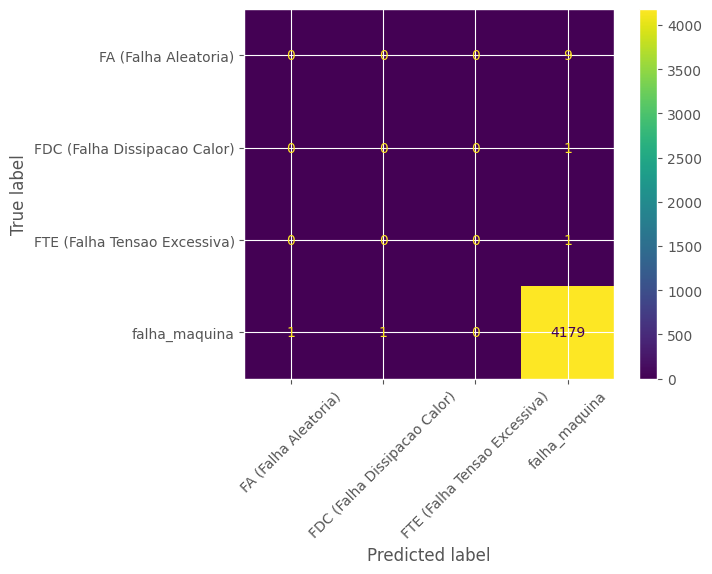

In [126]:
# Matriz de confusão, visualiza onde o modelo está acertando ou errando mais
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45)

In [128]:
from sklearn.model_selection import cross_val_score # Importa a função de validação cruzada

scores = cross_val_score(melhor_xgb, X, y, scoring='f1_macro', cv=5) # Executa validação cruzada
print(f"F1 Macro Médio: {scores.mean():.4f} ± {scores.std():.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:41:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:41:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:42:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:42:35] WARNING: /workspace/src/learner.cc:738: 
Para

F1 Macro Médio: 0.2819 ± 0.0416


<Figure size 1200x600 with 0 Axes>

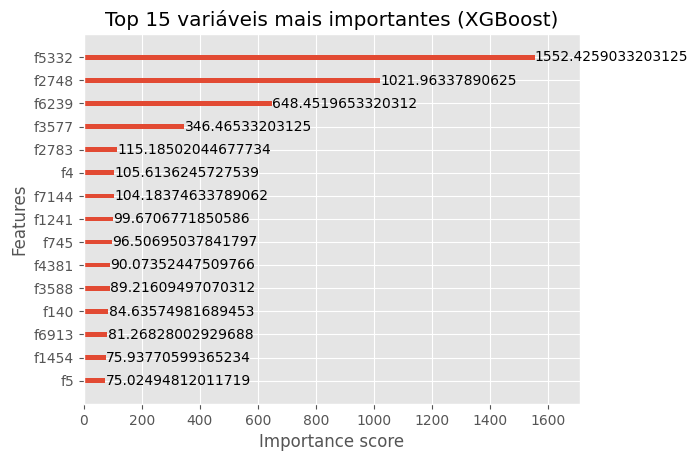

In [129]:
from xgboost import plot_importance

modelo_treinado = melhor_xgb.named_steps['classificador']

# Plot da importância das variáveis
plt.figure(figsize=(12, 6))
plot_importance(modelo_treinado, max_num_features=15, importance_type='gain')
plt.title("Top 15 variáveis mais importantes (XGBoost)")
plt.show()

In [72]:
# Função para calcular distância relativa ao intervalo
def distancia_relativa(valor, lim_inf, lim_sup):
    if valor < lim_inf:
        return lim_inf - valor
    elif valor > lim_sup:
        return valor - lim_sup
    else:
        return 0

# Aplicando para cada coluna
df['dist_temperatura_ar'] = df['temperatura_ar'].apply(lambda x: distancia_relativa(x, 293.10, 305.90))
df['dist_temperatura_processo'] = df['temperatura_processo'].apply(lambda x: distancia_relativa(x, 304.90, 314.50))
df['dist_umidade_relativa'] = df['umidade_relativa'].apply(lambda x: distancia_relativa(x, 90.00, 90.00))
df['dist_velocidade_rotacional'] = df['velocidade_rotacional'].apply(lambda x: distancia_relativa(x, 1159.00, 1823.00))
df['dist_torque'] = df['torque'].apply(lambda x: distancia_relativa(x, 16.45, 64.05))



In [18]:
# Soma dos outliers
df['qtd_outliers'] = df[['outlier_temperatura_ar', 'outlier_temperatura_processo',
                         'outlier_umidade_relativa', 'outlier_velocidade_rotacional',
                         'outlier_torque']].sum(axis=1)


In [22]:
#Criar Feature de Relações entre Variáveis
df['ratio_torque_velocidade'] = df['torque'] / df['velocidade_rotacional']
df['delta_temperatura'] = df['temperatura_processo'] - df['temperatura_ar']


In [25]:
# Separar as features (X) e a target (y)
X = df.drop(columns=['classe_defeito'])
y = df['classe_defeito']


In [28]:
#Padronizar novas Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_para_padronizar = ['dist_temperatura_ar', 'dist_temperatura_processo',
                             'dist_umidade_relativa', 'dist_velocidade_rotacional',
                             'dist_torque', 'ratio_torque_velocidade', 'delta_temperatura']

df[features_para_padronizar] = scaler.fit_transform(df[features_para_padronizar])



In [44]:

X = df.drop(columns=['classe_defeito', 'id', 'id_produto'])  # removendo colunas irrelevantes
y = df['classe_defeito']



In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
def remover_outliers_iqr(df, colunas):
    df_filtrado = df.copy()
    for col in colunas:
        q1 = df_filtrado[col].quantile(0.25)
        q3 = df_filtrado[col].quantile(0.75)
        iqr = q3 - q1
        limite_inf = q1 - 1.5 * iqr
        limite_sup = q3 + 1.5 * iqr
        df_filtrado = df_filtrado[
            (df_filtrado[col] >= limite_inf) &
            (df_filtrado[col] <= limite_sup)
        ]
    return df_filtrado

In [ ]:
# Faz a remoção dos outliers para cada classe, evitando viés por volume de dados
def remover_outliers_por_classe(df, colunas, classe_col):
    df_filtrado = pd.DataFrame()
    for classe in df[classe_col].unique():
        df_classe = df[df[classe_col] == classe]
        df_classe_filtrado = remover_outliers_iqr(df_classe, colunas)
        df_filtrado = pd.concat([df_filtrado, df_classe_filtrado])
    return df_filtrado

In [ ]:
import pandas as pd

df = pd.read_csv('/content/bootcamp_train.csv') #bootecamp train


In [108]:
colunas_falha = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)']

# 1. Substituir True/False por 1/0
df[colunas_falha] = df[colunas_falha].replace({True: 1, False: 0})

# 2. Substituir valores inválidos ('N', strings, etc.) por 0
df[colunas_falha] = df[colunas_falha].apply(pd.to_numeric, errors='coerce').fillna(0)

# 3. Converter para inteiro
df[colunas_falha] = df[colunas_falha].astype(int)

print(df[colunas_falha].dtypes)


falha_maquina                      int64
FDF (Falha Desgaste Ferramenta)    int64
FDC (Falha Dissipacao Calor)       int64
FP (Falha Potencia)                int64
FTE (Falha Tensao Excessiva)       int64
FA (Falha Aleatoria)               int64
dtype: object


In [ ]:
# Produto entre temperatura do processo e tempo de desgaste da ferramenta
df['temp_x_desgaste'] = df['temperatura_processo'] * df['desgaste_da_ferramenta']

# Razão entre torque e velocidade (indicativo de carga relativa)
df['razao_torque_rotacao'] = df['torque'] / (df['velocidade_rotacional'] + 1e-6)  # evita divisão por zero

# Produto entre temperatura ambiente e velocidade rotacional (condições operacionais)
df['temp_amb_x_rotacao'] = df['temperatura_ar'] * df['velocidade_rotacional']



In [ ]:
# Criação da coluna classe_defeito, vai ser a nossa variável target
colunas_falha = ['falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)',
    ]
if 'classe_defeito' not in df.columns:
    coluna_falha = colunas_falha_existentes = [c for c in colunas_falha if c in df.columns]



In [ ]:
# Garantir tipo inteiro nas falhas
for col in colunas_falha:
    df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['true', 'sim', '1'] else 0)


In [ ]:
#  Converter colunas de falha para numérico (int)
for c in colunas_falha_existentes:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

# **Novas features para representar razões e combinações que podem melhorar o modelo**

In [109]:
# Códificação do rótulo, transforma os nomes em inteiros
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [110]:
# Identificação das colunas númericas e categóricas
numericas = X.select_dtypes(include='number').columns.tolist()
# Include the 'Falha' columns in the categorical list if they exist in X
falha_columns_in_X = [col for col in colunas_falha if col in X.columns]
# Also include the original 'Falha' columns from the raw data if they exist in X
original_falha_columns_in_X = [col for col in ['FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)'] if col in X.columns]

categoricas = X.select_dtypes(include='object').columns.tolist()
# Ensure all relevant falha columns are in the categorical list and remove duplicates
categoricas = list(set(categoricas + falha_columns_in_X + original_falha_columns_in_X))

# Remove any columns from the numerical list if they are also in the categorical list
numericas = [col for col in numericas if col not in categoricas]

print("Colunas numéricas:", numericas)
print("Colunas categóricas:", categoricas)

Colunas numéricas: ['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'outlier_temperatura_ar', 'outlier_temperatura_processo', 'outlier_umidade_relativa', 'outlier_velocidade_rotacional', 'outlier_torque', 'qtd_outliers', 'dist_temperatura_ar', 'dist_temperatura_processo', 'dist_umidade_relativa', 'dist_velocidade_rotacional', 'dist_torque', 'ratio_torque_velocidade', 'delta_temperatura']
Colunas categóricas: ['tipo', 'id_produto']


In [111]:
# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [112]:
top_features_outliers = [
    'temperatura_ar', 'temperatura_processo', 'umidade_relativa',
    'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

In [113]:
# Pipelines de pré-processamento
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])

In [114]:
from sklearn.preprocessing import LabelEncoder

# Copiar DataFrame para não alterar o original
df_modelo = df.copy()

# Converter colunas categóricas para numéricas
colunas_categoricas = ['id_produto', 'tipo']
for col in colunas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))


In [115]:
colunas_falhas = ['falha_maquina',
        'FDC (Falha Dissipacao Calor)',
        'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)',
      'dissipacao_calor',
                 'falha_potencia', 'tensao_excessiva', 'falha_aleatoria'            ]

# Filtrar somente as colunas que existem no df_modelo
colunas_existentes = [col for col in colunas_falhas if col in df_modelo.columns]

# Aplicar a conversão somente nessas colunas
for col in colunas_existentes:
    df_modelo[col] = df_modelo[col].apply(lambda x: 1 if str(x).strip().lower() in ['sim', '1', 'true'] else 0)



In [116]:
print("Tamanho de y_train:", len(y_train))
print("Classes únicas em y_train:", set(y_train))

Tamanho de y_train: 16772
Classes únicas em y_train: {np.int64(0), np.int64(1)}


In [117]:
#Verifique a quantidade de classes no y_train
from xgboost import XGBClassifier
import numpy as np

num_classes = len(np.unique(y_train))
print([num_classes])



[2]


In [118]:
def remover_outliers_por_classe(df, features, target_col):
    df_filtrado = pd.DataFrame()
    for classe in df[target_col].unique():
        df_classe = df[df[target_col] == classe].copy()
        for f in features:
            if f in df_classe.columns:
                Q1 = df_classe[f].quantile(0.25)
                Q3 = df_classe[f].quantile(0.75)
                IQR = Q3 - Q1
                limite_inf = Q1 - 1.5*IQR
                limite_sup = Q3 + 1.5*IQR
                df_classe = df_classe[(df_classe[f] >= limite_inf) & (df_classe[f] <= limite_sup)]
        df_filtrado = pd.concat([df_filtrado, df_classe])
    return df_filtrado.reset_index(drop=True)

In [119]:
# Pipelines de pré-processamento
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])

# Definição do pipeline de modelagem com XGBoost + SMOTE
melhor_xgb = ImbPipeline(steps=[
    ('preprocessador', preprocessador), # Transforma dados
    ('smote', SMOTE(random_state=42)), # Balanceia classes de treino
    ('classificador', XGBClassifier( # Modelo de classificação XGBoost com hiperparâmetros otimizados
      objective='multi:softprob',
      eval_metric='mlogloss',
      n_estimators=312,
      learning_rate=0.092,
      max_depth=8,
      subsample=0.735,
      colsample_bytree=0.798,
      gamma=0.058,
      reg_alpha=0.888,
      reg_lambda=0.351,
      random_state=42
    ))
])


In [140]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# === 1. Carregar dataset ===
df = pd.read_csv('bootcamp_train.csv')

# === 2. Lista de colunas de falhas e conversão para 0/1 ===
colunas_falha = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

for col in colunas_falha:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() in ['sim', '1', 'true'] else 0)

# === 3. Criar coluna target 'classe_defeito' ===
colunas_falha_existentes = [c for c in colunas_falha if c in df.columns]
if 'classe_defeito' not in df.columns:
    df['classe_defeito'] = df[colunas_falha_existentes].idxmax(axis=1).astype(str)

# === 4. Lista de features para remoção de outliers ===
top_features_outliers = [
    'temperatura_ar', 'temperatura_processo', 'umidade_relativa',
    'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta'
]

min_amostras = df_limpo['classe_defeito'].value_counts().min()

# === 5. Função robusta para remover outliers por classe ===
def remover_outliers_por_classe_robusto(df, features, target_col, min_amostras=5):
    """
    Remove outliers usando IQR por classe.
    Garante que cada classe tenha pelo menos min_amostras.
    """
    df_filtrado = pd.DataFrame()
    for classe in df[target_col].unique():
        df_classe = df[df[target_col] == classe].copy()
        for f in features:
            if f in df_classe.columns:
                Q1 = df_classe[f].quantile(0.25)
                Q3 = df_classe[f].quantile(0.75)
                IQR = Q3 - Q1
                limite_inf = Q1 - 1.5 * IQR
                limite_sup = Q3 + 1.5 * IQR
                df_classe = df_classe[(df_classe[f] >= limite_inf) & (df_classe[f] <= limite_sup)]
        # Se a classe ficou vazia, mantém os min_amostras mais próximas da mediana
        if len(df_classe) < min_amostras:
            df_classe = df[df[target_col] == classe].copy()
            for f in features:
                if f in df_classe.columns:
                    mediana = df_classe[f].median()
                    df_classe = df_classe[df_classe[f].between(mediana*0.5, mediana*1.5)]
        df_filtrado = pd.concat([df_filtrado, df_classe], ignore_index=True)
    return df_filtrado

# Remove outliers
df_limpo = remover_outliers_por_classe_robusto(df, top_features_outliers, 'classe_defeito')

# === 6. Verificação das classes após remoção de outliers ===
print("Quantidade de amostras por classe após remoção de outliers:")
contagem_classes = df_limpo['classe_defeito'].value_counts()
print(contagem_classes)

# Identificar classes com 0 amostras (se houver)
classes_vazias = contagem_classes[contagem_classes == 0].index.tolist()
if classes_vazias:
    print("\nAtenção! Algumas classes estão vazias:", classes_vazias)
else:
    print("\nTodas as classes têm amostras suficientes para o treino.")

# === 7. Separar X e y ===
X = df_limpo.drop(columns=colunas_falha_existentes + ['classe_defeito'])
y = df_limpo['classe_defeito']

# Codificar rótulos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# === 8. Divisão treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 9. Pré-processamento ===
numericas = X.select_dtypes(include='number').columns.tolist()
categoricas = X.select_dtypes(include='object').columns.tolist()

numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])

# === 10. Pipeline XGBoost + SMOTE ===
melhor_xgb = ImbPipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', SMOTE(random_state=42,k_neighbors=1)),
    ('classificador', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        n_estimators=312,
        learning_rate=0.092,
        max_depth=8,
        subsample=0.735,
        colsample_bytree=0.798,
        gamma=0.058,
        reg_alpha=0.888,
        reg_lambda=0.351,
        random_state=42,
        use_label_encoder=False
    ))
])




Quantidade de amostras por classe após remoção de outliers:
classe_defeito
falha_maquina                   20903
FA (Falha Aleatoria)               45
FDC (Falha Dissipacao Calor)        5
FTE (Falha Tensao Excessiva)        3
Name: count, dtype: int64

Todas as classes têm amostras suficientes para o treino.


In [131]:
print(df_limpo[colunas_falha_existentes].sum())


falha_maquina                      312
FDF (Falha Desgaste Ferramenta)     42
FDC (Falha Dissipacao Calor)       136
FP (Falha Potencia)                 12
FTE (Falha Tensao Excessiva)        83
FA (Falha Aleatoria)                47
dtype: int64


In [132]:
df['classe_defeito_corrigida'] = df['classe_defeito'].replace({
    'FA (Falha Aleatoria)': 'outros',
    'FDC (Falha Dissipacao Calor)': 'outros',
    'FTE (Falha Tensao Excessiva)': 'outros'
})


In [149]:
from sklearn.metrics import classification_report
# === 11. Treinamento e predição ===
melhor_xgb.fit(X_train, y_train)
y_pred = melhor_xgb.predict(X_test)
# Previsões de classes
y_pred = melhor_xgb.predict(X_test)

# Previsões de probabilidades (necessário para ROC)
y_proba = melhor_xgb.predict_proba(X_test)


# === 12. Avaliação do modelo ===
print("\nClassificação com XGBoost:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:53:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classificação com XGBoost:
                              precision    recall  f1-score   support

        FA (Falha Aleatoria)       0.00      0.00      0.00         9
FDC (Falha Dissipacao Calor)       0.00      0.00      0.00         1
FTE (Falha Tensao Excessiva)       0.00      0.00      0.00         1
               falha_maquina       1.00      1.00      1.00      4181

                    accuracy                           1.00      4192
                   macro avg       0.25      0.25      0.25      4192
                weighted avg       0.99      1.00      1.00      4192



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


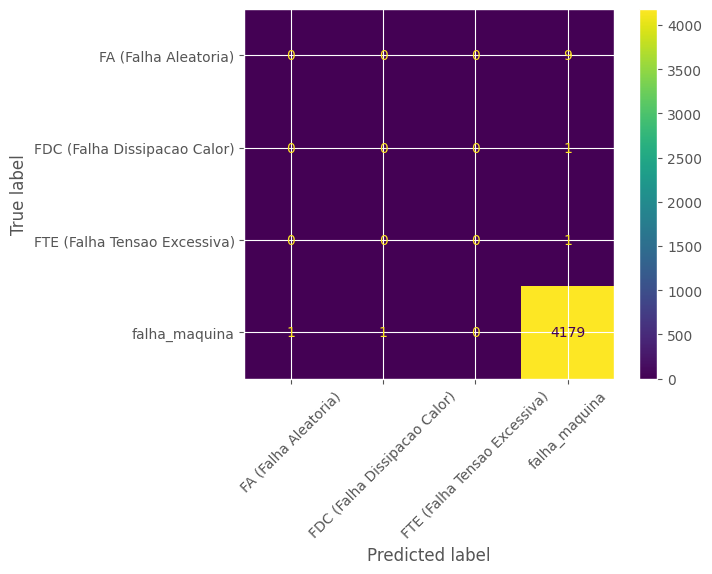

In [124]:
# Matriz de confusão, visualiza onde o modelo está acertando ou errando mais
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45)

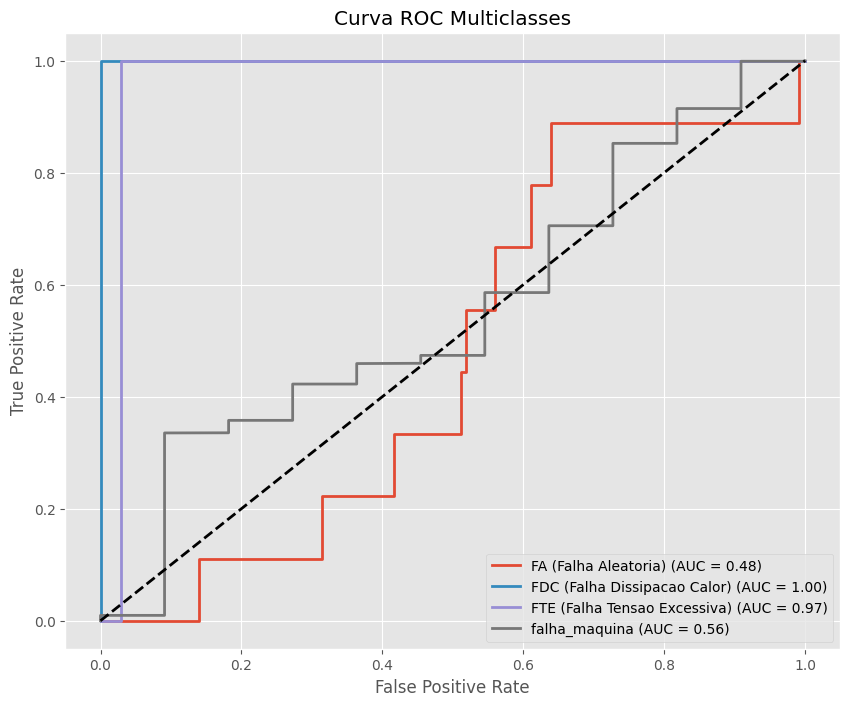

In [152]:
num_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{label_encoder.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')


plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multiclasses')
plt.legend(loc='lower right')
plt.show()

In [153]:
from sklearn.model_selection import cross_val_score # Importa a função de validação cruzada

scores = cross_val_score(melhor_xgb, X, y, scoring='f1_macro', cv=5) # Executa validação cruzada
print(f"F1 Macro Médio: {scores.mean():.4f} ± {scores.std():.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:33:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:33:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:34:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:34:33] WARNING: /workspace/src/learner.cc:738: 
Para

F1 Macro Médio: 0.2819 ± 0.0416


<Figure size 1200x600 with 0 Axes>

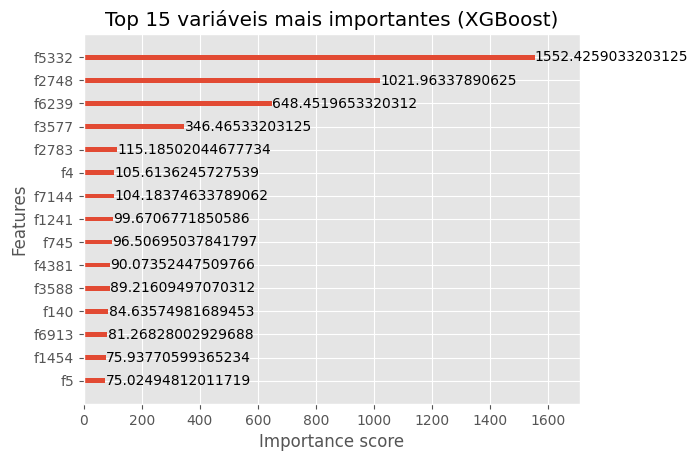

In [154]:
from xgboost import plot_importance

modelo_treinado = melhor_xgb.named_steps['classificador']

# Plot da importância das variáveis
plt.figure(figsize=(12, 6))
plot_importance(modelo_treinado, max_num_features=15, importance_type='gain')
plt.title("Top 15 variáveis mais importantes (XGBoost)")
plt.show()

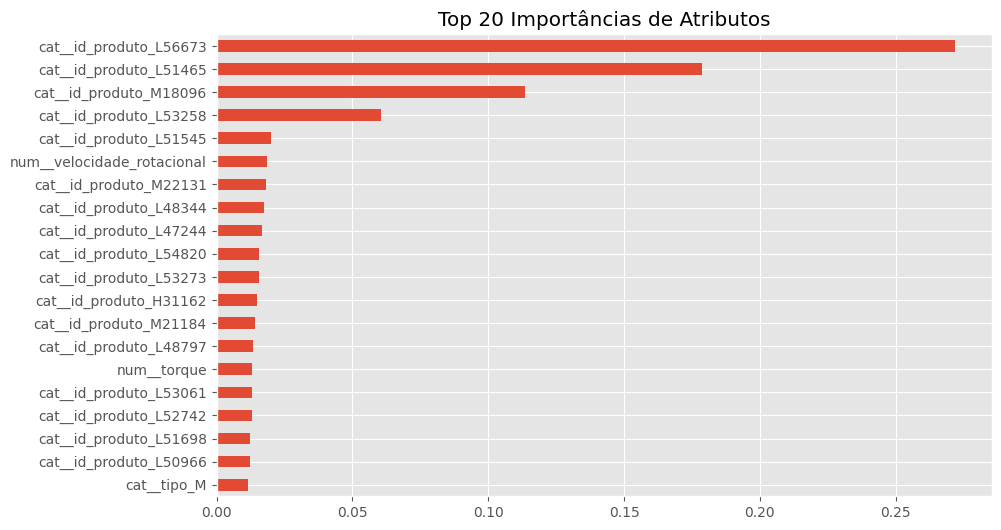

In [155]:
import matplotlib.pyplot as plt

modelo_final = melhor_xgb.named_steps['classificador']
importancias = modelo_final.feature_importances_
nomes_colunas = melhor_xgb.named_steps['preprocessador'].get_feature_names_out()

importancias_df = pd.Series(importancias, index=nomes_colunas).sort_values(ascending=False)[:20]
importancias_df.plot(kind='barh', figsize=(10,6))
plt.title("Top 20 Importâncias de Atributos")
plt.gca().invert_yaxis()
plt.show()

In [171]:
df_teste = pd.read_csv('/content/bootcamp_train.csv')

In [173]:
# Calcula as novas features, assim como no treino
df['outlier_temperatura_ar'] = ((df['temperatura_ar'] < 293.10) | (df['temperatura_ar'] > 305.90)).astype(int)
df['outlier_temperatura_processo'] = ((df['temperatura_processo'] < 304.90) | (df['temperatura_processo'] > 314.50)).astype(int)
df['outlier_umidade_relativa'] = ((df['umidade_relativa'] < 90.00) | (df['umidade_relativa'] > 90.00)).astype(int)
df['outlier_velocidade_rotacional'] = ((df['velocidade_rotacional'] < 1159.00) | (df['velocidade_rotacional'] > 1823.00)).astype(int)
df['outlier_torque'] = ((df['torque'] < 16.45) | (df['torque'] > 64.05)).astype(int)

# Visualiza a estrutura
df_teste.info()

# O ID vai ser usado no final para a submissão
ids = df_teste['id']
# Recebe o dataframe completo, exceto os rotulos
X_teste = df_teste

# aplica o modelo treinado no conjunto de teste
y_pred_label = melhor_xgb.predict(X_teste) # são os rotulos numéricos previstos
y_pred_classe = label_encoder.inverse_transform(y_pred_label) # converte os números de volta para os nomes

# cria um dataframe de colunas binárias e preenche com 1 apenas na classe prevista de cada amostra
df_resultado = pd.DataFrame(0, index=range(len(y_pred_classe)), columns=[
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)',
    'falha_maquina'
])
for i, classe in enumerate(y_pred_classe):
    df_resultado.loc[i, classe] = 1

# adiciona a coluna de id
df_resultado.insert(0, 'id', ids)

import os

# cria a pasta se não existir
os.makedirs('../outputs', exist_ok=True)

# salva o CSV
df_resultado.to_csv('../outputs/submissao_final.csv', index=False)
print("Arquivo 'submissao_final.csv' gerado com sucesso!")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               35260 non-null  int64  
 1   id_produto                       35260 non-null  object 
 2   tipo                             35260 non-null  object 
 3   temperatura_ar                   34644 non-null  float64
 4   temperatura_processo             34661 non-null  float64
 5   umidade_relativa                 35260 non-null  float64
 6   velocidade_rotacional            34509 non-null  float64
 7   torque                           34637 non-null  float64
 8   desgaste_da_ferramenta           34308 non-null  float64
 9   falha_maquina                    35260 non-null  object 
 10  FDF (Falha Desgaste Ferramenta)  35260 non-null  object 
 11  FDC (Falha Dissipacao Calor)     35260 non-null  object 
 12  FP (Falha Potencia